# The TensorFlow Way 

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import numpy as np

# Operations in a computational graph

In [2]:
sess = tf.Session()

x_vals = np.array([1.,3.,5.,7.,9.])
x_data = tf.placeholder(tf.float32)
m_const = tf.constant(3.)
my_product = tf.multiply(x_data,m_const)
for x_val in x_vals:
    print(sess.run(my_product,feed_dict={x_data:x_val}))

3.0
9.0
15.0
21.0
27.0


# Layering nested operations
연산 그래프에서 다층 연산을 쌓는 방법

다음 예시를 참조

In [20]:
# 1. feed in하고 placeholder에 대응할 데이터를 정의한다.
my_array = np.array([[1.,3.,5.,7.,9.],
                    [-2.,0.,2.,4.,6.],
                    [-6.,-3.,0.,3.,6.]])
x_vals = np.array([my_array,my_array+1])
x_data = tf.placeholder(tf.float32,shape=(3,5))
# x_data = tf.placeholder(tf.float32,shape=(None,None))으로 쓰는 것도 가능

In [21]:
# 2. 행렬곱에 사용할 상수를 정의한다.
m1 = tf.constant([[1.],[0.],[-1.],[2.],[4.]])
m2 = tf.constant([[2.]])
a1= tf.constant([[10.]])

In [22]:
# 3. 연산을 선언하고 연상들을 그래프에 추가한다.
prod1 = tf.matmul(x_data,m1)
prod2 = tf.matmul(prod1,m2)
add1 = tf.add(prod2,a1)

In [23]:
# 4. 그래프에 데이터를 feed 한다.
for x_val in x_vals:
    print(sess.run(add1,feed_dict={x_data:x_val}))

[[102.]
 [ 66.]
 [ 58.]]
[[114.]
 [ 78.]
 [ 70.]]


placeholder 정의할 때 shape를 지정해야하는데 여러가지일 수 있는 모양을 None으로 대체할 수 있다.<br>
단 fixed size로 차원을 standardizing하려할 떄 사이즈를 정확히 입력해야하므로 가능한한 차원을 제대로 입력해주는 것이 좋다.

# Working with multiple layers
custom layer를 비롯해 다양한 층을 가장 좋게 쌓는 법을 학습한다.

예를 들어 어떤 이미지를 대표하는 데이터를 만들어내고자할 때 이런 연산을 이해하는 가장 좋은 방법은 example과 연산을 수행할 built-in 층을 어떻게 사용할지 살펴보는 것이다. 이런 탐색을 수행할 첫번쨰 층을 moving window라고 부른다.

In [24]:
# 1. 2D 이미지 생성(4x4 pixel), 4개의 차원으로 구성하는데 첫번째와 마지막 차원은 1 사이즈를 갖는다.
# 각각 이미지 넘버, 높이, 깊이, 채널

x_shape = [1,4,4,1]
x_val = np.random.uniform(size=x_shape)

In [25]:
# 2. 심플 이미지를 feed할 수 있는 placeholder를 정의
x_data = tf.placeholder(tf.float32,shape=x_shape)

In [ ]:
# 3. 4x4이미지에 대한 moving_window를 만들기 위해 2x2 모양의 창을 사용해 convolute하는 내장함수를 사용하기로 한다.(conv2d)

my_filter = tf.constant(0.25,shape=[2,2,1,1])
my_strides = [1,2,2,1]
mov_avg_layer = tf.nn.conv2d(x_data,filter = my_filter,strides = my_strides,
                            padding='SAME',name='Moving_Avg_Window')

Output_size = (W-F+2P)/S + 1, W : input_size, F : filter_size, P : padding of zeros, S : stride

In [28]:
# 4. moving_window의 2x2 결과에 대해 연산을 수행할 custom 층을 정의
# squeeze 함수는 차원 중 사이즈가 1인 것을 찾아 제거한다. ex) [[[[1],[2]],[[3],[4]]]] -> [[1,2],[3,4]]

def custom_layer(input_matrix):
    input_matrix_squeezed = tf.squeeze(input_matrix)
    A = tf.constant([[1.,2.],[-1.,3.]])
    b = tf.constant(1.,shape=[2,2])
    temp1 = tf.matmul(A,input_matrix_squeezed)
    temp = tf.add(temp1,b) # Ax+b
    return tf.sigmoid(temp)

In [29]:
# 5. name_scope를 통해 새로운 층을 쌓을 수 있는데 이는 연산 그래프에서 identifiable하고 collapsible(접을 수 있는),expandable하다.
with tf.name_scope('Custom_Layer') as scope:
    custom_layer1 = custom_layer(mov_avg_layer)
    print(sess.run(custom_layer1,feed_dict={x_data:x_val}))

[[0.91568214 0.8890658 ]
 [0.8505936  0.7587084 ]]


# Implementing backpropagation

In [43]:
# 1. 2.
sess = tf.Session()

# 3.
x_vals = np.random.normal(1,0.1,100)
y_vals = np.repeat(10.,100)
x_data = tf.placeholder(shape=[1],dtype=tf.float32)
y_target = tf.placeholder(shape=[1],dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[1]))

# 4.
my_output = tf.multiply(x_data,A)

# 5. 
loss = tf.square(my_output - y_target)

# 6. optimization을 선언, GradientDescentOptimizer은 학습률을 기반으로 경사하강법을 수행한다.
# 학습률이 너무 크면 발산, 너무 작으면 수렴하는데에 지나치게 오랜 시간이 걸리므로 적절한 학습률을 선택해야한다.
my_opt = tf.train.GradientDescentOptimizer(learning_rate=0.02)
train_step = my_opt.minimize(loss)

# 7.
init = tf.global_variables_initializer()
sess.run(init)

# 8.
for i in range(100):
    rand_index = np.random.choice(100)
    rand_x = [x_vals[rand_index]]
    rand_y = [y_vals[rand_index]]
    sess.run(train_step, feed_dict={x_data:rand_x, y_target:rand_y})
    if (i+1) % 25 == 0:
        print('Step # {}, A = {}, \n Loss = {}'.\
              format(i+1,sess.run(A),sess.run(loss,feed_dict={x_data:rand_x,y_target:rand_y})))


Step # 25, A = [6.7133064], 
 Loss = [10.746827]
Step # 50, A = [8.811204], 
 Loss = [0.97156245]
Step # 75, A = [9.551101], 
 Loss = [0.6305945]
Step # 100, A = [9.578607], 
 Loss = [0.01097469]


# Implementing loss functions
loss function은 타겟과 예측을 비교해 수치적인 차이를 나타낸다.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
sess = tf.Session()

In [6]:
# 회귀
# 1. 
x_vals = tf.linspace(-1.,1.,500)
target = tf.constant(0.)

# 2. L2 norm : Euclidean loss function, a great loss 타겟을 향해 수렴하는데 그 차이가 0에 가까워질 수록 천천히 수렴한다.
# 내장함수 : tf.nn.l2_loss()
l2_y_vals = tf.square(target - x_vals)
l2_y_out = sess.run(l2_y_vals)

# 3. L1 norm : Huber loss function, 큰 값에 대해 steep 하지 않은 것이 장점. 하지만 smooth하지 않아 잘 수렴하지 않을 수 있다.
l1_y_vals = tf.abs(target-x_vals)
l1_y_out = sess.run(l1_y_vals)

# 4. Pseudo-Huber loss : continuous and smooth approximation to Huber loss function.
# delta 파라미터에 의존해 얼마나 steep할지 결정된다.
delta1 = tf.constant(0.25)
phuber1_y_vals = tf.multiply(tf.square(delta1),tf.sqrt(1.+tf.square((target-x_vals)/delta1))-1.)
phuber1_y_out = sess.run(phuber1_y_vals)

delta2 = tf.constant(5.)
phuber2_y_vals = tf.multiply(tf.square(delta2),tf.sqrt(1.+tf.square((target-x_vals)/delta2))-1.)
phuber2_y_out = sess.run(phuber2_y_vals)

In [13]:
# 분류
# 5. 데이터셋 생성
x_vals = tf.linspace(-3.,5.,500)
target = tf.constant(1.)
targets = tf.fill([500,],1.)

# 6. Hinge loss : support vector machine과 신경망에 주로 쓰인다.
hinge_y_vals = tf.maximum(0.,1.-tf.multiply(target,x_vals))
hinge_y_out = sess.run(hinge_y_vals)

# 7. logistic loss function
xentropy_y_vals = -tf.multiply(target,tf.log(x_vals)) - tf.multiply((1.-target),tf.log(1.-x_vals))
xentropy_y_out = sess.run(xentropy_y_vals)

# 8. sigmoid cross-entropy loss
xentropy_sigmoid_y_vals = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_vals,labels=targets)
xentropy_sigmoid_y_out = sess.run(xentropy_sigmoid_y_vals)

# 9. Weighted cross_entropy loss
weight = tf.constant(0.5)
xentropy_weighted_y_vals = tf.nn.weighted_cross_entropy_with_logits(logits=x_vals,labels=targets,pos_weight=weight)
xentropy_weighted_y_out = sess.run(xentropy_sigmoid_y_vals)

그외 다양한 loss function 들<br>

7.8번은 비슷한데 8번은 sigmoid를 한번 적용하고 log안에 집어넣는다.<br>
https://gombru.github.io/2018/05/23/cross_entropy_loss/ 참고

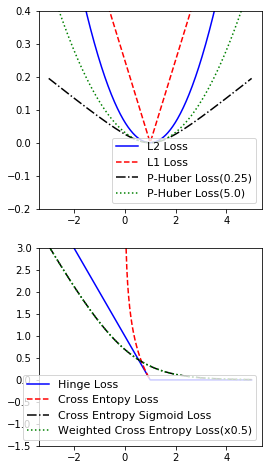

In [19]:
fig,ax = plt.subplots(2,1,figsize=(4,8))
x_array = sess.run(x_vals)
ax[0].plot(x_array,l2_y_out,'b-',label='L2 Loss')
ax[0].plot(x_array,l1_y_out,'r--',label='L1 Loss')
ax[0].plot(x_array,phuber1_y_out,'k-.',label='P-Huber Loss(0.25)')
ax[0].plot(x_array,phuber2_y_out,'g:',label='P-Huber Loss(5.0)')
ax[0].set_ylim(-0.2,0.4)
ax[0].legend(loc='lower right',prop={'size':11})

ax[1].plot(x_array,hinge_y_out,'b-',label='Hinge Loss')
ax[1].plot(x_array,xentropy_y_out,'r--',label='Cross Entopy Loss')
ax[1].plot(x_array,xentropy_sigmoid_y_out,'k-.',label='Cross Entropy Sigmoid Loss')
ax[1].plot(x_array,xentropy_weighted_y_out,'g:',label='Weighted Cross Entropy Loss(x0.5)')
ax[1].set_ylim(-1.5,3)
ax[1].legend(loc='lower right',prop={'size':11})

In [3]:
np.random.normal(1,0.1,100).shape

(100,)

In [5]:
np.concatenate((np.repeat(0,50),np.repeat(0,50))).shape

(100,)

In [ ]:
# tf.expand_dims(행렬, 위치=0,1,2,...)
# 해당 위치에 차원을 추가
# ex)B = tf.expand_dims(A,1) : A.shape=(2,2,2) -> B.shape(2,1,2,2)

# Working with batch and stochastic training
오직 하나의 데이터로부터 역전파 연산을 수행하는 것은 매우 이상한 학습 프로세스가 될 수 있고, 한번에 너무 큰 배치를 이요하는 것은 연산 비용이 많이 든다. 올바른 타입의 학습을 고르는 것은 머신러닝 알고리즘이 해로 수렴하는데 있어 매우 중요하다.

Stochastic 학습이란 한번에 오직 하나의 데이터 pair를 이용해 과정을 진행해 나가는 것이다. 트레이닝에 있어서의 배치는 하나에서부터 데이터셋 전체까지 다양하게 선택할 수 있다.

In [51]:
sess = tf.Session()

# 1.
batch_size = 20

# 2. 데이터 선언
x_vals = np.random.normal(1,0.1,100)
y_vals = np.repeat(10.,100)
# 이전에 챕터 1에서는 20으로 명시해두었지만 None으로 일반화하는 것도 가능하다.
x_data = tf.placeholder(shape=[None,1],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[1,1]))

# 3. 연산 선언
my_output = tf.matmul(x_data,A)

In [52]:
# 4. loss 함수 선언 : L2 norm
loss = tf.reduce_mean(tf.square(my_output - y_target))

# 5. optimizer 선언 (초기화 직전)
my_opt = tf.train.GradientDescentOptimizer(0.02)
train_step = my_opt.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)

In [53]:
# 6. training step을 반복, 시간에 따른 loss를 비교하고 sgd에 대한 배치학습을 비교하고자 하므로,
# 매 5번 간격마다 loss 함수를 저장한다.

batch_size = 20

loss_batch = []
for i in range(100):
    rand_index = np.random.choice(100,size=batch_size)
    rand_x = np.transpose([x_vals[rand_index]])
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data:rand_x, y_target:rand_y})
    if (i+1) % 5 == 0:
        print('Step #' + str(i+1)+ 'A = '+str(sess.run(A)))
        temp_loss = sess.run(loss,feed_dict={x_data:rand_x,y_target:rand_y})
        print('Loss = ',str(temp_loss))
        loss_batch.append(temp_loss)

Step #5A = [[1.0330156]]
Loss =  81.06793
Step #10A = [[2.6760044]]
Loss =  52.158913
Step #15A = [[4.025011]]
Loss =  35.00647
Step #20A = [[5.1215672]]
Loss =  24.88947
Step #25A = [[6.003374]]
Loss =  16.061527
Step #30A = [[6.730427]]
Loss =  11.213324
Step #35A = [[7.3128567]]
Loss =  7.9525604
Step #40A = [[7.7976546]]
Loss =  6.2259226
Step #45A = [[8.194846]]
Loss =  2.968799
Step #50A = [[8.5182705]]
Loss =  2.9906743
Step #55A = [[8.765683]]
Loss =  2.139413
Step #60A = [[8.97167]]
Loss =  1.7558815
Step #65A = [[9.130928]]
Loss =  1.8605238
Step #70A = [[9.2996435]]
Loss =  1.4699075
Step #75A = [[9.408749]]
Loss =  0.83209383
Step #80A = [[9.493129]]
Loss =  1.3426905
Step #85A = [[9.545008]]
Loss =  1.342288
Step #90A = [[9.626984]]
Loss =  1.1457132
Step #95A = [[9.693028]]
Loss =  1.3378861
Step #100A = [[9.725347]]
Loss =  0.8200917


In [54]:
# 이번엔 배치 사이즈 없이 sgd를 수행
sess.run(init)
loss_stochastic = []
for i in range(100):
    rand_index = np.random.choice(100)
    rand_x = np.array([x_vals[rand_index]]).reshape(-1,1)
    rand_y = np.array([y_vals[rand_index]]).reshape(-1,1)
    sess.run(train_step, feed_dict={x_data:rand_x, y_target:rand_y})
    if (i+1) % 5 == 0:
        print('Step #' + str(i+1)+ 'A = '+str(sess.run(A)))
        temp_loss = sess.run(loss,feed_dict={x_data:rand_x, y_target:rand_y})
        print('Loss = ',str(temp_loss))
        loss_stochastic.append(temp_loss)

Step #5A = [[0.52456963]]
Loss =  90.71841
Step #10A = [[2.2984028]]
Loss =  60.421215
Step #15A = [[3.7266347]]
Loss =  43.861786
Step #20A = [[4.895607]]
Loss =  22.516327
Step #25A = [[5.831299]]
Loss =  18.10992
Step #30A = [[6.6151085]]
Loss =  13.307697
Step #35A = [[7.2856493]]
Loss =  17.18947
Step #40A = [[7.7528005]]
Loss =  4.353859
Step #45A = [[8.1886635]]
Loss =  7.3730073
Step #50A = [[8.489073]]
Loss =  4.332226
Step #55A = [[8.662735]]
Loss =  0.46409455
Step #60A = [[8.968719]]
Loss =  1.3282632
Step #65A = [[9.036872]]
Loss =  0.6613004
Step #70A = [[9.163707]]
Loss =  0.5496086
Step #75A = [[9.276388]]
Loss =  0.74735045
Step #80A = [[9.462588]]
Loss =  1.0445821
Step #85A = [[9.572483]]
Loss =  1.1466041
Step #90A = [[9.628677]]
Loss =  0.47340006
Step #95A = [[9.694491]]
Loss =  0.91582304
Step #100A = [[9.719352]]
Loss =  5.685331


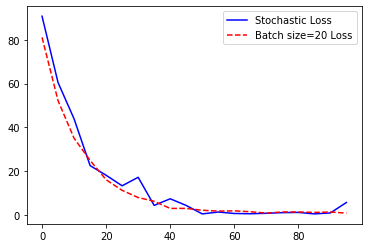

In [55]:
fig,ax = plt.subplots(1,1)
ax.plot(range(0,100,5),loss_stochastic,'b-',label='Stochastic Loss')
ax.plot(range(0,100,5),loss_batch,'r--',label='Batch size=20 Loss')
ax.legend()

batch에서의 loss가 더 smooth한 것을 확인할 수 있다.

# Combinig everything together
iris 분류 문제를 통해 체크해볼 것

In [56]:
# 1.
from sklearn.datasets import load_iris
iris = load_iris()

# 2.
# 원래 iris 데이터는 삼진분류이지만 이진분류 문제로 바꿔서 수행해본다.
binary_target = np.array([1. if x==0 else 0. for x in iris.target])
# 특성도 두개만 사용한다.
iris_2d = np.array([[x[2],x[3]] for x in iris.data])

In [58]:
# 3. 
batch_size = 20
x1_data = tf.placeholder(shape=[None,1],dtype=tf.float32)
x2_data = tf.placeholder(shape=[None,1],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[1,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))
# tf.float32을 사용하는 것 대신 floats에 대한 byte를 낮춤으로서 performance를 향상시킬 수 있다.

In [69]:
# 4. linear model을 정의 : x2 = x1*A + b
# loss function을 x2 - x1*A - b로 바로 정의하지 않고 sigmoid를 이용한 entropy함수로 정의한다.
my_mult = tf.matmul(x2_data,A)
my_add = tf.add(my_mult,b)
my_output = tf.subtract(x1_data,my_add)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=my_output,labels=y_target)

# 5.
my_opt = tf.train.GradientDescentOptimizer(0.05)
train_step = my_opt.minimize(xentropy)

In [71]:
# 1.
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from sklearn.datasets import load_iris
iris = load_iris()

# 2.
# 원래 iris 데이터는 삼진분류이지만 이진분류 문제로 바꿔서 수행해본다.
binary_target = np.array([1. if x==0 else 0. for x in iris.target])
# 특성도 두개만 사용한다.
iris_2d = np.array([[x[2],x[3]] for x in iris.data])

# 3. 
batch_size = 20
x1_data = tf.placeholder(shape=[None,1],dtype=tf.float32)
x2_data = tf.placeholder(shape=[None,1],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[1,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))
# tf.float32을 사용하는 것 대신 floats에 대한 byte를 낮춤으로서 performance를 향상시킬 수 있다.

# 4. linear model을 정의 : x2 = x1*A + b
# loss function을 x2 - x1*A - b로 바로 정의하지 않고 sigmoid를 이용한 entropy함수로 정의한다.
my_mult = tf.matmul(x2_data,A)
my_add = tf.add(my_mult,b)
my_output = tf.subtract(x1_data,my_add)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=my_output,labels=y_target)

# 5.
my_opt = tf.train.GradientDescentOptimizer(0.05)
train_step = my_opt.minimize(xentropy)
# 6.
init = tf.global_variables_initializer()
sess.run(init)

for i in range(1000):
    rand_index = np.random.choice(len(iris_2d),size=batch_size)
    rand_x = iris_2d[rand_index]
    rand_x1 = np.array([[x[0]] for x in rand_x])
    rand_x2 = np.array([[x[1]] for x in rand_x])
    rand_y = np.array([[y] for y in binary_target[rand_index]])
    sess.run(train_step, feed_dict = {x1_data:rand_x1, x2_data:rand_x2, y_target:rand_y})
    if (i+1) % 200 == 0:
        print('Step # '+str(i+1)+' A = '+str(sess.run(A))+ ' b = '+str(sess.run(b)))

Step # 200 A = [[8.817873]] b = [[-3.6621735]]
Step # 400 A = [[10.289753]] b = [[-4.8236656]]
Step # 600 A = [[11.17636]] b = [[-5.513713]]
Step # 800 A = [[11.8661995]] b = [[-6.033299]]
Step # 1000 A = [[12.435761]] b = [[-6.426067]]


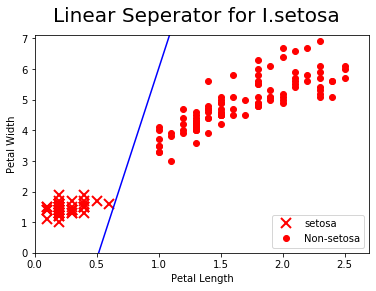

In [75]:
[[slope]] = sess.run(A)
[[intercept]] = sess.run(b)
x = np.linspace(0,3,50)
ablineValues = []
for i in x:
    ablineValues.append(slope*i+intercept)
    
setosa_x = [a[1] for i,a in enumerate(iris_2d) if binary_target[i]==1]
setosa_y = [a[0] for i,a in enumerate(iris_2d) if binary_target[i]==1]
non_setosa_x = [a[1] for i,a in enumerate(iris_2d) if binary_target[i]==0]
non_setosa_y = [a[0] for i,a in enumerate(iris_2d) if binary_target[i]==0]

plt.plot(setosa_x,setosa_y,'rx',ms=10,mew=2,label='setosa')
plt.plot(non_setosa_x,non_setosa_y,'ro',label='Non-setosa')
plt.plot(x,ablineValues,'b-')
plt.xlim([0.0,2.7])
plt.ylim([0.0,7.1])
plt.suptitle('Linear Seperator for I.setosa',fontsize=20)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend(loc='lower right')

# Evaluating models
훈련 도중에 모델을 평가하는 것은 알고리즘에 대한 인사이트와 디버그와 모델의 전체적인 향상, 변화에 대한 힌트를 제공한다.

훈련 이후에는 training set과 test set을 나눠 모델을 평가한다.

만일 우리가 배치 트레이닝을 수행했다면 그러한 배치에서의 예측에 모델을 재활용할 수 있다. 만일 stochastic하게 트레이닝을 수행했다면 아마 배치에서 데이터를 처리하는 evaluator를 따로 분리해야할 것이다.

모델 output에 대한 변환을 수행하는 loss function(예를 들어 sigmoid cross entropy with logits)을 모델에 포함시켰다면, 예측에 대한 정확도를 계산하도록 고려해야만 한다.

평가에 있어서 중요한 또 한가지는 모델이 회귀모델인가, 분류모델인가이다.

회귀모델에서는 연속적인 수를 예측한다. 그렇기 때문에 타겟이 카테고리로 나눠지지 않는다. 이런 회귀모델을 평가하기 위해 실제값과 예측값의 차이를 측정하는 수단을 생각해야만 한다.

분류모델은 수치적인 입력값에 기초한 카테고리를 예측하는 것이다. 실제 예측값은 1과 0의 연속된 수열로 나타나게 된다. 회귀모델에서의 loss 함수는 모델이 얼마나 잘 작동하고 있는지 측정하는데 유용하지 않다. 보통은 올바로 분류된 카테고리의 퍼센테이지를 계산하는 정확도를 사용한다.

두 모델을 사용해보는데 있어 이미 사용한 예시를 다시 실행해볼 것이다.

In [77]:
# 1. x_vals와 y_vals의 관계식을 추정하는 모델

sess = tf.Session()
x_vals = np.random.normal(1,0.1,100)
y_vals = np.repeat(10.,100)
x_data = tf.placeholder(shape=[None,1],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)

batch_size = 25

train_indices = np.random.choice(len(x_vals),round(len(x_vals)*0.8),replace=False)
test_indices = np.array(list(set(range(len(x_vals)))-set(train_indices)))

x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]
A = tf.Variable(tf.random_normal(shape=[1,1]))

In [78]:
# 2.
my_output = tf.matmul(x_data,A)
loss = tf.reduce_mean(tf.square(my_output - y_target))
my_opt = tf.train.GradientDescentOptimizer(0.02)
train_step = my_opt.minimize(loss)

init = tf.global_variables_initializer()


In [84]:
# 2.
my_output = tf.matmul(x_data,A)
loss = tf.reduce_mean(tf.square(my_output - y_target))
my_opt = tf.train.GradientDescentOptimizer(0.02)
train_step = my_opt.minimize(loss)
init = tf.global_variables_initializer()

# 3.
sess.run(init)
for i in range(100):
    rand_index = np.random.choice(len(x_vals_train),size=batch_size)
    rand_x = np.transpose(x_vals_train[rand_index]).reshape(-1,1)
    rand_y = np.transpose(y_vals_train[rand_index]).reshape(-1,1)
    sess.run(train_step,feed_dict={x_data:rand_x, y_target:rand_y})
    if (i+1) % 25 == 0:
        print('Step #'+str(i+1)+' A = '+str(sess.run(A)))
        print('Loss = '+str(sess.run(loss,feed_dict={x_data:rand_x,y_target:rand_y})))

Step #25 A = [[6.330137]]
Loss = 13.6523905
Step #50 A = [[8.602901]]
Loss = 2.6414142
Step #75 A = [[9.4002075]]
Loss = 0.96566564
Step #100 A = [[9.667089]]
Loss = 0.5310863


In [85]:
# 4. 평가, MSE를 loss function으로 train set과 test set에 대해 결과값을 확인
mse_test = sess.run(loss,feed_dict={x_data:np.transpose([x_vals_test]),y_target:np.transpose([y_vals_test])})
mse_train = sess.run(loss,feed_dict={x_data:np.transpose([x_vals_train]),y_target:np.transpose([y_vals_train])})
print('MSE on test : ', str(np.round(mse_test,2)))
print('MSE on train : ',str(np.round(mse_train,2)))

MSE on test :  0.73
MSE on train :  0.98


In [20]:
# 다른 데이터로 분류 수행
# N(-1,1)과 N(2,1) 중 어디에 속했는지 구분
sess = tf.Session()
sess.run(tf.global_variables_initializer())
x_vals = np.concatenate((np.random.normal(-1,1,50),np.random.normal(2,1,50)))
y_vals = np.concatenate((np.repeat(0.,50),np.repeat(1.,50)))

x_data = tf.placeholder(shape=[1,None],dtype=tf.float32)
y_target = tf.placeholder(shape=[1,None],dtype=tf.float32)

batch_size = 25

train_indices = np.random.choice(len(x_vals),round(len(x_vals)*0.8),replace=False)
test_indices = np.array(list(set(range(len(x_vals)))-set(train_indices)))

x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]
A = tf.Variable(tf.random_normal(mean=10,shape=[1]))

my_output = tf.add(x_data,A)
init = tf.initialize_all_variables()
sess.run(init)
xentropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = my_output,labels = y_target))
my_opt = tf.train.GradientDescentOptimizer(0.05)
train_step = my_opt.minimize(xentropy)

for i in range(1800):
    rand_index = np.random.choice(len(x_vals_train),size=batch_size)
    rand_x = np.array([x_vals_train[rand_index]]).reshape(1,-1)
    rand_y = np.array([y_vals_train[rand_index]]).reshape(1,-1)
    sess.run(train_step,feed_dict={x_data:rand_x, y_target:rand_y})
    if (i+1)%200==0:
        print('Step # {}  A = {}'.format(i+1,sess.run(A)))
        print('Loss = '+str(sess.run(xentropy,feed_dict={x_data:rand_x, y_target:rand_y})))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Step # 200  A = [5.0971327]
Loss = 1.8716083
Step # 400  A = [1.3129373]
Loss = 0.49577513
Step # 600  A = [0.06657664]
Loss = 0.25675905
Step # 800  A = [-0.28130966]
Loss = 0.24927638
Step # 1000  A = [-0.3770991]
Loss = 0.25240546
Step # 1200  A = [-0.37442356]
Loss = 0.23265344
Step # 1400  A = [-0.3965956]
Loss = 0.21087971
Step # 1600  A = [-0.4061097]
Loss = 0.16603509
Step # 1800  A = [-0.39062107]
Loss = 0.19967304


In [27]:
# 평가(evaluate)
y_prediction = tf.squeeze(tf.round(tf.nn.sigmoid(tf.add(x_data,A))))
correct_prediction = tf.equal(y_prediction, y_target)
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
acc_value_test = sess.run(accuracy,feed_dict={x_data:[x_vals_test],y_target:[y_vals_test]})
acc_value_train = sess.run(accuracy,feed_dict={x_data:[x_vals_train],y_target:[y_vals_train]})

print('Accuracy on train set : '+str(acc_value_train))
print('Accuracy on test set : '+str(acc_value_test))

Accuracy on train set : 0.95
Accuracy on test set : 0.85


Text(0.5, 1.0, 'Binary Classifier, Accuracy=0.8500000238418579')

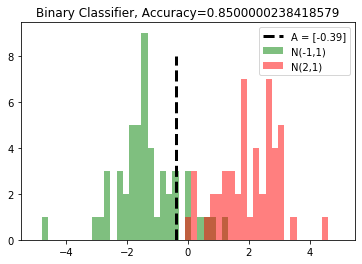

In [28]:
# 그림
A_result = sess.run(A)
bins = np.linspace(-5,5,50)
plt.hist(x_vals[0:50],bins,alpha=0.5,label='N(-1,1)',color='green')
plt.hist(x_vals[50:100],bins[0:50],alpha=0.5,label='N(2,1)',color='red')
plt.plot((A_result,A_result),(0,8),'k--',linewidth=3,label='A = {}'.format(np.round(A_result,2)))
plt.legend(loc='upper right')
plt.title('Binary Classifier, Accuracy={}'.format(np.round(acc_value_test,2)))

In [24]:
sess.run(my_output,feed_dict={x_data:rand_x})

array([[ 1.7635697 , -1.7822067 ,  1.8479465 ,  1.4306592 ,  2.6337266 ,
         0.6311717 ,  1.7635697 , -2.2690315 , -1.0094159 , -2.6449142 ,
         2.501305  ,  0.73900247, -1.6030768 ,  1.0191772 ,  1.1299903 ,
         2.250855  ,  2.6337266 , -2.2344675 ,  1.0191772 ,  0.3454765 ,
         0.90580714,  2.534163  ,  2.1663942 , -1.6030768 , -2.037371  ]],
      dtype=float32)

In [25]:
rand_y

array([[1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 0.]])

In [26]:
rand_x

array([[ 2.15419082, -1.39158563,  2.23856756,  1.82128028,  3.02434783,
         1.02179272,  2.15419082, -1.87841042, -0.61879481, -2.25429306,
         2.8919264 ,  1.12962358, -1.2124557 ,  1.40979822,  1.52061145,
         2.641476  ,  3.02434783, -1.84384658,  1.40979822,  0.73609755,
         1.29642824,  2.92478387,  2.55701515, -1.2124557 , -1.64674982]])

In [30]:
sess.run(y_prediction,feed_dict={x_data:rand_x})

array([1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 0.], dtype=float32)